In [1]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
mndata = MNIST('./MNIST/python-mnist/data')
%matplotlib inline

In [2]:
def get_mnist_dataset(size_train,size_test):
    images, labels = mndata.load_training()
    
    size = size_train + size_test
    
    images = images[:size]
    labels = labels[:size]
    
    X = np.array(images)
    L = np.array(labels)
    
    X = X / 255.0
    
    L = L.reshape((len(labels),1))

    Y = np.zeros((len(labels),10))
    
    Y[np.arange(len(labels)) , L.T] = 1

    
    x_train = X[range(0,size_train)]
    y_train = Y[range(0,size_train)]
    
    
    x_test = X[range(size_train, size)]
    y_test = Y[range(size_train, size)]
    return x_train.T,y_train.T, x_test.T, y_test.T

In [3]:
def forward_linear_tanh(X,W,b):
    Z = np.dot(W,X) + b
    A = np.tanh(Z)
    
    return A,Z

In [4]:
def sigmoid(A):
    return 1.0 / (1 + np.exp( - A))

In [5]:
def forward_linear_sigmoid(X,W,b):

    Z = np.dot(W,X) + b
    A = sigmoid(Z)
    
    return A,Z

In [6]:
def forward(parameters,X):
    
    number_layers = len(parameters)//2 + 1
    
#     print("b.shape = " + str(parameters["b1"].shape))
    
    cache = {}
    cache["A0"] = X
    
    A = X
    
    for i in range(1,number_layers - 1):
        A , Z = forward_linear_tanh(A,parameters["W" + str(i)], parameters["b" + str(i)])
        cache["A" + str(i)] = A
        cache["Z" + str(i)] = Z
        
    A, Z = forward_linear_sigmoid(A,parameters["W" + str(number_layers - 1)],
                               parameters["b" + str(number_layers - 1)])
    cache["A" + str(number_layers - 1)] = A
    cache["Z" + str(number_layers - 1)] = Z

    return cache

In [7]:
def backward_linear_sigmoid(dA,W,A_prev,Z):
    n = A_prev.shape[1]
    
    dZ = np.multiply(dA,np.multiply(sigmoid(Z), sigmoid(1 - Z)))
    
    dW = np.dot(dZ,A_prev.T) / n
    
    db = np.sum(dZ, axis = 1) / n
    db = db.reshape((dZ.shape[0],1))
    
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [8]:
def backward_linear_tanh(dA,W,A_prev,Z):
    n = A_prev.shape[1]
    
    dZ = np.multiply(dA,1 - np.power(np.tanh(Z),2))
    
    dW = np.dot(dZ,A_prev.T) / n
    
    db = np.sum(dZ, axis = 1) / n
    db = db.reshape((dZ.shape[0],1))
    
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [9]:
def backward(A_Z_cached,parameters,Y):
    
    number_layers = len(parameters)//2 + 1
    
    A_last_layer = A_Z_cached["A" + str(number_layers - 1)]
    
    derivatives_A = {}
    derivatives = {}
    
    # does not work ((
    derivatives_A["dA" + str(number_layers - 1)] = (A_last_layer - Y) / (A_last_layer - np.power(A_last_layer,2))
    
#     derivatives_A["dA" + str(number_layers - 1)] = (A_last_layer - Y)
    
    #for the last layer with sigmoid
    W = parameters["W" + str(number_layers - 1)]
    dA = derivatives_A["dA" + str(number_layers - 1)]
    A_prev = A_Z_cached["A" + str(number_layers - 2)]
    Z = A_Z_cached["Z" + str(number_layers - 1)]
    
    dA_prev, dW, db = backward_linear_sigmoid(dA,W,A_prev,Z)
    
    derivatives_A["dA" + str(number_layers - 2)] = dA_prev
    derivatives["dW" + str(number_layers - 1)] = dW
    derivatives["db" + str(number_layers - 1)] = db
    #
    
    #for layers number_layers - 2 --> 1
    for l in reversed(range(1,number_layers - 1)):
        W = parameters["W" + str(l)]
        dA = derivatives_A["dA" + str(l)]
        A_prev = A_Z_cached["A" + str(l - 1)]
        Z = A_Z_cached["Z" + str(l)]
        
        dA_prev, dW, db = backward_linear_tanh(dA,W,A_prev,Z)
        
        derivatives_A["dA" + str(l - 1)] = dA_prev
        derivatives["dW" + str(l)] = dW
        derivatives["db" + str(l)] = db
    
    return derivatives

In [10]:
def calculate_cost(X,Y,parameters):
    
    A_Z_cache = forward(parameters,X)
    
    number_layers = len(parameters)//2 + 1
    
    n = X.shape[1]
    
    A = A_Z_cache["A" + str(number_layers - 1)]
    
    cost = - (np.multiply(Y,np.log(A)) + np.multiply(1 - Y , np.log(1 - A)))
    
    cost = np.sum(cost) / n
    
    return cost

In [11]:
def calculate_accuracy(X,Y,parameters):
    
#     print("b.shape = " + str(parameters["b1"].shape))
    
    A_Z_cache = forward(parameters,X)
    
    number_layers = len(parameters)//2 + 1
    
    n = X.shape[1]
    
    A = A_Z_cache["A" + str(number_layers - 1)]
    
    Y_ans = np.argmax(Y, axis = 0)
    
    A_ans = np.argmax(A, axis = 0)
    
    accuracy = np.sum((Y_ans == A_ans)) / n
    
    return accuracy

In [12]:
def generate_parameters(layers_size):
    parameters = {}
    
    for l in range(1,len(layers_size)):
        parameters["W" + str(l)] = np.random.randn(layers_size[l],layers_size[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_size[l],1))
#         print("b" + str(l)+ ".shape = "  + str(parameters["b" + str(l)].shape))
        
    return parameters

In [17]:
def train_model(X,Y,learning_rate ,number_epoch ,layers_size ,X_test,Y_test,parameters):
    
    
#     print("b.shape = " + str(parameters["b1"].shape))
    
    number_layers = len(layers_size)
    
    train_accuracy = []
    test_accuracy = []

    train_cost = []
    test_cost = []
    
    for i in range(0,number_epoch):
        
        print("iter = " + str(i))
        
        train_accuracy_temp = calculate_accuracy(X,Y,parameters)
        test_accuracy_temp = calculate_accuracy(X_test,Y_test,parameters)
        
        print("Train accuracy = " + str(train_accuracy_temp))
        print("Test accuracy = " + str(test_accuracy_temp))
        
        train_accuracy.append(train_accuracy_temp)
        test_accuracy.append(test_accuracy_temp)
        
        train_cost_temp = calculate_cost(X,Y,parameters)
        train_cost.append(train_cost_temp)
        
        test_cost_temp = calculate_cost(X_test,Y_test,parameters) 
        test_cost.append(test_cost_temp)
        
        print("Train cost = " + str(train_cost_temp))
        print("Test cost = " + str(test_cost_temp))
        
        print("")
        
        A_Z_cached = forward(parameters,X)
        
        derivatives = backward(A_Z_cached,parameters,Y)
        
#         print("derivative = " + str(derivatives))

        for l in range(1,number_layers):
#             print("before")
#             print("W" + str(l) + str(parameters["W" + str(l)]))
            
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * derivatives["dW" + str(l)]
            parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * derivatives["db" + str(l)]
            
#             print("-->derivatives['db' + str(l).shape] = " + str(derivatives["db" + str(l)].shape))
            
#             print("after")
#             print("W" + str(l) + str(parameters["W" + str(l)]))
        
    return parameters, train_accuracy, test_accuracy ,train_cost , test_cost

iter = 0
Train accuracy = 0.089
Test accuracy = 0.07
Train cost = 6.91977163502
Test cost = 6.92240588513

iter = 1
Train accuracy = 0.104
Test accuracy = 0.079
Train cost = 6.84194037771
Test cost = 6.84400902877

iter = 2
Train accuracy = 0.112
Test accuracy = 0.086
Train cost = 6.76595718272
Test cost = 6.76747506003

iter = 3
Train accuracy = 0.128
Test accuracy = 0.101
Train cost = 6.6910882131
Test cost = 6.69206421318

iter = 4
Train accuracy = 0.1385
Test accuracy = 0.116
Train cost = 6.61671307083
Test cost = 6.61715080467

iter = 5
Train accuracy = 0.146
Test accuracy = 0.124
Train cost = 6.54230953094
Test cost = 6.54220786948

iter = 6
Train accuracy = 0.1535
Test accuracy = 0.13
Train cost = 6.46744264879
Test cost = 6.46679620238

iter = 7
Train accuracy = 0.1625
Test accuracy = 0.138
Train cost = 6.39175709928
Test cost = 6.39055665719

iter = 8
Train accuracy = 0.174
Test accuracy = 0.155
Train cost = 6.31497185513
Test cost = 6.31320480646

iter = 9
Train accuracy = 0.

Train accuracy = 0.574
Test accuracy = 0.586
Train cost = 3.35674920226
Test cost = 3.33337497692

iter = 76
Train accuracy = 0.5755
Test accuracy = 0.583
Train cost = 3.35231570455
Test cost = 3.32903630066

iter = 77
Train accuracy = 0.577
Test accuracy = 0.584
Train cost = 3.34811366191
Test cost = 3.32492850481

iter = 78
Train accuracy = 0.5825
Test accuracy = 0.585
Train cost = 3.34412718264
Test cost = 3.3210355339

iter = 79
Train accuracy = 0.584
Test accuracy = 0.586
Train cost = 3.34034147977
Test cost = 3.31734245552

iter = 80
Train accuracy = 0.5845
Test accuracy = 0.588
Train cost = 3.33674279367
Test cost = 3.31383538132

iter = 81
Train accuracy = 0.585
Test accuracy = 0.589
Train cost = 3.33331831991
Test cost = 3.31050139346

iter = 82
Train accuracy = 0.587
Test accuracy = 0.589
Train cost = 3.3300561421
Test cost = 3.30732847607

iter = 83
Train accuracy = 0.5885
Test accuracy = 0.591
Train cost = 3.32694516933
Test cost = 3.30430545154

iter = 84
Train accuracy = 

iter = 150
Train accuracy = 0.6725
Test accuracy = 0.659
Train cost = 3.22851158284
Test cost = 3.2085242423

iter = 151
Train accuracy = 0.674
Test accuracy = 0.66
Train cost = 3.22741280857
Test cost = 3.2074305672

iter = 152
Train accuracy = 0.674
Test accuracy = 0.659
Train cost = 3.2263134644
Test cost = 3.20633573063

iter = 153
Train accuracy = 0.6745
Test accuracy = 0.659
Train cost = 3.22521344284
Test cost = 3.20523963811

iter = 154
Train accuracy = 0.675
Test accuracy = 0.659
Train cost = 3.22411264236
Test cost = 3.20414220079

iter = 155
Train accuracy = 0.6755
Test accuracy = 0.66
Train cost = 3.22301096698
Test cost = 3.20304333508

iter = 156
Train accuracy = 0.6765
Test accuracy = 0.662
Train cost = 3.22190832595
Test cost = 3.20194296232

iter = 157
Train accuracy = 0.677
Test accuracy = 0.663
Train cost = 3.22080463342
Test cost = 3.20084100842

iter = 158
Train accuracy = 0.6775
Test accuracy = 0.663
Train cost = 3.21969980807
Test cost = 3.19973740357

iter = 159

Train cost = 3.14214293614
Test cost = 3.12150551617

iter = 225
Train accuracy = 0.7085
Test accuracy = 0.693
Train cost = 3.14087900798
Test cost = 3.12022379606

iter = 226
Train accuracy = 0.7085
Test accuracy = 0.694
Train cost = 3.13961205976
Test cost = 3.11893890383

iter = 227
Train accuracy = 0.7085
Test accuracy = 0.695
Train cost = 3.13834207891
Test cost = 3.11765082887

iter = 228
Train accuracy = 0.709
Test accuracy = 0.695
Train cost = 3.13706905296
Test cost = 3.11635956066

iter = 229
Train accuracy = 0.7095
Test accuracy = 0.694
Train cost = 3.13579296952
Test cost = 3.11506508873

iter = 230
Train accuracy = 0.7095
Test accuracy = 0.694
Train cost = 3.13451381635
Test cost = 3.11376740266

iter = 231
Train accuracy = 0.7095
Test accuracy = 0.694
Train cost = 3.1332315813
Test cost = 3.11246649212

iter = 232
Train accuracy = 0.71
Test accuracy = 0.694
Train cost = 3.13194625231
Test cost = 3.11116234682

iter = 233
Train accuracy = 0.7105
Test accuracy = 0.694
Train

iter = 299
Train accuracy = 0.7085
Test accuracy = 0.698
Train cost = 3.03824120021
Test cost = 3.0159401816

iter = 300
Train accuracy = 0.709
Test accuracy = 0.698
Train cost = 3.03672272847
Test cost = 3.01439591019

iter = 301
Train accuracy = 0.709
Test accuracy = 0.698
Train cost = 3.03520058137
Test cost = 3.01284788461

iter = 302
Train accuracy = 0.709
Test accuracy = 0.698
Train cost = 3.03367475464
Test cost = 3.01129610103

iter = 303
Train accuracy = 0.7095
Test accuracy = 0.699
Train cost = 3.03214524416
Test cost = 3.00974055579

iter = 304
Train accuracy = 0.709
Test accuracy = 0.7
Train cost = 3.03061204596
Test cost = 3.00818124535

iter = 305
Train accuracy = 0.7095
Test accuracy = 0.7
Train cost = 3.02907515618
Test cost = 3.0066181663

iter = 306
Train accuracy = 0.7095
Test accuracy = 0.7
Train cost = 3.02753457114
Test cost = 3.00505131539

iter = 307
Train accuracy = 0.7095
Test accuracy = 0.7
Train cost = 3.0259902873
Test cost = 3.00348068949

iter = 308
Train

iter = 374
Train accuracy = 0.707
Test accuracy = 0.698
Train cost = 2.91405860683
Test cost = 2.88963069944

iter = 375
Train accuracy = 0.7075
Test accuracy = 0.697
Train cost = 2.91226344714
Test cost = 2.88780490646

iter = 376
Train accuracy = 0.708
Test accuracy = 0.697
Train cost = 2.91046475231
Test cost = 2.88597552798

iter = 377
Train accuracy = 0.7075
Test accuracy = 0.697
Train cost = 2.9086625313
Test cost = 2.88414257333

iter = 378
Train accuracy = 0.707
Test accuracy = 0.697
Train cost = 2.90685679328
Test cost = 2.88230605209

iter = 379
Train accuracy = 0.707
Test accuracy = 0.696
Train cost = 2.90504754764
Test cost = 2.88046597402

iter = 380
Train accuracy = 0.707
Test accuracy = 0.696
Train cost = 2.90323480395
Test cost = 2.87862234909

iter = 381
Train accuracy = 0.707
Test accuracy = 0.696
Train cost = 2.90141857199
Test cost = 2.87677518746

iter = 382
Train accuracy = 0.707
Test accuracy = 0.697
Train cost = 2.89959886175
Test cost = 2.87492449951

iter = 38

Train cost = 2.77248123358
Test cost = 2.74567681012

iter = 449
Train accuracy = 0.6965
Test accuracy = 0.692
Train cost = 2.7704616333
Test cost = 2.74362396588

iter = 450
Train accuracy = 0.6965
Test accuracy = 0.692
Train cost = 2.76843969064
Test cost = 2.74156876025

iter = 451
Train accuracy = 0.6965
Test accuracy = 0.692
Train cost = 2.76641542831
Test cost = 2.73951121638

iter = 452
Train accuracy = 0.6965
Test accuracy = 0.692
Train cost = 2.76438886916
Test cost = 2.73745135756

iter = 453
Train accuracy = 0.6965
Test accuracy = 0.692
Train cost = 2.76236003617
Test cost = 2.73538920721

iter = 454
Train accuracy = 0.696
Test accuracy = 0.692
Train cost = 2.76032895247
Test cost = 2.73332478889

iter = 455
Train accuracy = 0.695
Test accuracy = 0.692
Train cost = 2.75829564131
Test cost = 2.73125812629

iter = 456
Train accuracy = 0.696
Test accuracy = 0.692
Train cost = 2.75626012607
Test cost = 2.72918924325

iter = 457
Train accuracy = 0.696
Test accuracy = 0.692
Train 

iter = 523
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.61617642639
Test cost = 2.58685509921

iter = 524
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.61405087997
Test cost = 2.58469607122

iter = 525
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.61192492753
Test cost = 2.5825366499

iter = 526
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.60979859574
Test cost = 2.58037686235

iter = 527
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.60767191121
Test cost = 2.5782167356

iter = 528
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.60554490054
Test cost = 2.57605629666

iter = 529
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.60341759025
Test cost = 2.57389557248

iter = 530
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.60129000682
Test cost = 2.57173458998

iter = 531
Train accuracy = 0.69
Test accuracy = 0.692
Train cost = 2.59916217669
Test cost = 2.569573376

iter = 532
Train accura

iter = 598
Train accuracy = 0.694
Test accuracy = 0.695
Train cost = 2.45734949137
Test cost = 2.4255831724

iter = 599
Train accuracy = 0.694
Test accuracy = 0.695
Train cost = 2.45526233703
Test cost = 2.42346481133

iter = 600
Train accuracy = 0.694
Test accuracy = 0.695
Train cost = 2.45317653692
Test cost = 2.42134785615

iter = 601
Train accuracy = 0.694
Test accuracy = 0.695
Train cost = 2.4510921099
Test cost = 2.41923232639

iter = 602
Train accuracy = 0.694
Test accuracy = 0.695
Train cost = 2.44900907469
Test cost = 2.41711824144

iter = 603
Train accuracy = 0.6945
Test accuracy = 0.696
Train cost = 2.44692744988
Test cost = 2.41500562056

iter = 604
Train accuracy = 0.694
Test accuracy = 0.696
Train cost = 2.44484725389
Test cost = 2.41289448285

iter = 605
Train accuracy = 0.694
Test accuracy = 0.697
Train cost = 2.44276850501
Test cost = 2.41078484729

iter = 606
Train accuracy = 0.694
Test accuracy = 0.697
Train cost = 2.44069122138
Test cost = 2.40867673269

iter = 607


iter = 673
Train accuracy = 0.7
Test accuracy = 0.706
Train cost = 2.30566605276
Test cost = 2.27175145589

iter = 674
Train accuracy = 0.7
Test accuracy = 0.706
Train cost = 2.3037228932
Test cost = 2.26978300728

iter = 675
Train accuracy = 0.7005
Test accuracy = 0.706
Train cost = 2.30178209677
Test cost = 2.26781702982

iter = 676
Train accuracy = 0.7005
Test accuracy = 0.707
Train cost = 2.29984367157
Test cost = 2.26585353237

iter = 677
Train accuracy = 0.7005
Test accuracy = 0.708
Train cost = 2.29790762558
Test cost = 2.26389252362

iter = 678
Train accuracy = 0.7005
Test accuracy = 0.708
Train cost = 2.29597396663
Test cost = 2.26193401215

iter = 679
Train accuracy = 0.701
Test accuracy = 0.708
Train cost = 2.29404270243
Test cost = 2.25997800642

iter = 680
Train accuracy = 0.701
Test accuracy = 0.708
Train cost = 2.29211384058
Test cost = 2.25802451474

iter = 681
Train accuracy = 0.701
Test accuracy = 0.708
Train cost = 2.29018738853
Test cost = 2.2560735453

iter = 682
T

Train cost = 2.16864266909
Test cost = 2.13319159555

iter = 748
Train accuracy = 0.7115
Test accuracy = 0.714
Train cost = 2.16688869432
Test cost = 2.13142202975

iter = 749
Train accuracy = 0.711
Test accuracy = 0.714
Train cost = 2.16513737945
Test cost = 2.12965527307

iter = 750
Train accuracy = 0.712
Test accuracy = 0.714
Train cost = 2.16338872498
Test cost = 2.12789132629

iter = 751
Train accuracy = 0.7125
Test accuracy = 0.715
Train cost = 2.16164273135
Test cost = 2.12613019018

iter = 752
Train accuracy = 0.713
Test accuracy = 0.715
Train cost = 2.1598993989
Test cost = 2.12437186536

iter = 753
Train accuracy = 0.713
Test accuracy = 0.715
Train cost = 2.15815872792
Test cost = 2.12261635243

iter = 754
Train accuracy = 0.713
Test accuracy = 0.715
Train cost = 2.15642071863
Test cost = 2.12086365186

iter = 755
Train accuracy = 0.7135
Test accuracy = 0.715
Train cost = 2.15468537115
Test cost = 2.11911376408

iter = 756
Train accuracy = 0.7135
Test accuracy = 0.715
Train c

iter = 822
Train accuracy = 0.732
Test accuracy = 0.734
Train cost = 2.04443121263
Test cost = 2.00823763549

iter = 823
Train accuracy = 0.732
Test accuracy = 0.734
Train cost = 2.04287393034
Test cost = 2.00667636649

iter = 824
Train accuracy = 0.733
Test accuracy = 0.734
Train cost = 2.0413191844
Test cost = 2.00511778851

iter = 825
Train accuracy = 0.733
Test accuracy = 0.734
Train cost = 2.03976697153
Test cost = 2.00356189816

iter = 826
Train accuracy = 0.733
Test accuracy = 0.734
Train cost = 2.03821728841
Test cost = 2.00200869198

iter = 827
Train accuracy = 0.733
Test accuracy = 0.734
Train cost = 2.03667013172
Test cost = 2.0004581665

iter = 828
Train accuracy = 0.734
Test accuracy = 0.734
Train cost = 2.03512549808
Test cost = 1.9989103182

iter = 829
Train accuracy = 0.7345
Test accuracy = 0.734
Train cost = 2.0335833841
Test cost = 1.99736514354

iter = 830
Train accuracy = 0.7345
Test accuracy = 0.734
Train cost = 2.03204378637
Test cost = 1.99582263895

iter = 831
T

Train cost = 1.93580367116
Test cost = 1.89972037159

iter = 897
Train accuracy = 0.747
Test accuracy = 0.745
Train cost = 1.93442380654
Test cost = 1.89834740027

iter = 898
Train accuracy = 0.7475
Test accuracy = 0.745
Train cost = 1.93304618277
Test cost = 1.89697680678

iter = 899
Train accuracy = 0.748
Test accuracy = 0.745
Train cost = 1.93167079544
Test cost = 1.89560858642

iter = 900
Train accuracy = 0.748
Test accuracy = 0.745
Train cost = 1.93029764015
Test cost = 1.89424273446

iter = 901
Train accuracy = 0.7485
Test accuracy = 0.745
Train cost = 1.92892671245
Test cost = 1.89287924617

iter = 902
Train accuracy = 0.749
Test accuracy = 0.745
Train cost = 1.92755800794
Test cost = 1.8915181168

iter = 903
Train accuracy = 0.75
Test accuracy = 0.745
Train cost = 1.92619152217
Test cost = 1.89015934163

iter = 904
Train accuracy = 0.751
Test accuracy = 0.744
Train cost = 1.92482725072
Test cost = 1.88880291591

iter = 905
Train accuracy = 0.7505
Test accuracy = 0.744
Train cos

iter = 971
Train accuracy = 0.76
Test accuracy = 0.756
Train cost = 1.83823251271
Test cost = 1.80302503227

iter = 972
Train accuracy = 0.7605
Test accuracy = 0.756
Train cost = 1.83700841607
Test cost = 1.8018172244

iter = 973
Train accuracy = 0.7605
Test accuracy = 0.757
Train cost = 1.83578623009
Test cost = 1.80061144041

iter = 974
Train accuracy = 0.7605
Test accuracy = 0.758
Train cost = 1.8345659505
Test cost = 1.79940767575

iter = 975
Train accuracy = 0.761
Test accuracy = 0.759
Train cost = 1.83334757306
Test cost = 1.79820592587

iter = 976
Train accuracy = 0.7615
Test accuracy = 0.759
Train cost = 1.83213109352
Test cost = 1.79700618621

iter = 977
Train accuracy = 0.7615
Test accuracy = 0.76
Train cost = 1.83091650766
Test cost = 1.79580845224

iter = 978
Train accuracy = 0.7615
Test accuracy = 0.76
Train cost = 1.82970381125
Test cost = 1.79461271941

iter = 979
Train accuracy = 0.7615
Test accuracy = 0.76
Train cost = 1.82849300007
Test cost = 1.79341898321

iter = 98

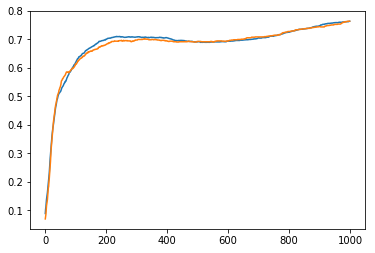

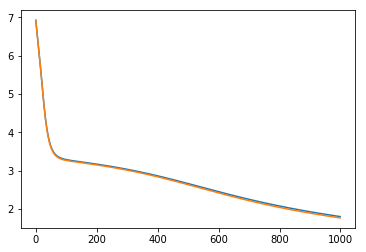

In [16]:

x_train, y_train, x_test, y_test = get_mnist_dataset(2000,1000)

# x_train = np.random.randn(3,10) * 0.001
# y_train = np.zeros((1,10))
parameters = parameters = generate_parameters(layers_size)
parameters, train_accuracy , test_accuracy ,train_cost, test_cost = train_model(x_train,y_train,0.005, 100, [784,800,10], x_test, y_test,parameters)

print("Train accuracy = " + str(calculate_accuracy(x_train,y_train,parameters)))

print("test accuracy = " + str(calculate_accuracy(x_test,y_test,parameters)))

# print("Test accuracy = " + str(calculate_accuracy(x_test,y_test,parameters)))

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()


plt.plot(train_cost)
plt.plot(test_cost)
plt.show()

iter = 0
Train accuracy = 0.8975
Test accuracy = 0.875
Train cost = 0.729813001667
Test cost = 0.878032573582

iter = 1
Train accuracy = 0.8995
Test accuracy = 0.878
Train cost = 0.71604852374
Test cost = 0.866641242374

iter = 2
Train accuracy = 0.8985
Test accuracy = 0.881
Train cost = 0.704128204857
Test cost = 0.856896285263

iter = 3
Train accuracy = 0.901
Test accuracy = 0.884
Train cost = 0.693734784969
Test cost = 0.848593892036

iter = 4
Train accuracy = 0.9025
Test accuracy = 0.885
Train cost = 0.684438385555
Test cost = 0.841154953795

iter = 5
Train accuracy = 0.904
Test accuracy = 0.886
Train cost = 0.676276763745
Test cost = 0.834921463605

iter = 6
Train accuracy = 0.905
Test accuracy = 0.888
Train cost = 0.668656575686
Test cost = 0.828847534539

iter = 7
Train accuracy = 0.9055
Test accuracy = 0.89
Train cost = 0.662144425171
Test cost = 0.824252640646

iter = 8
Train accuracy = 0.9065
Test accuracy = 0.892
Train cost = 0.655509896433
Test cost = 0.818761808194

iter =

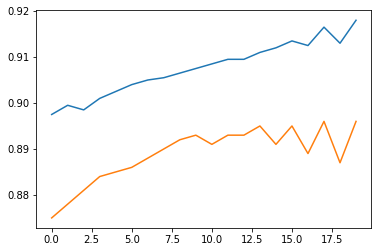

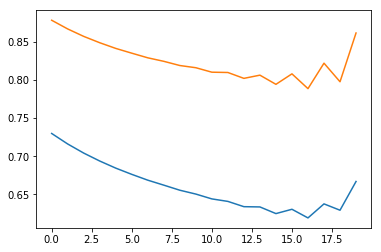

In [30]:
parameters, train_accuracy , test_accuracy ,train_cost, test_cost = train_model(x_train,y_train,0.2, 20, [784,800,10], x_test, y_test,parameters)

print("Train accuracy = " + str(calculate_accuracy(x_train,y_train,parameters)))

print("test accuracy = " + str(calculate_accuracy(x_test,y_test,parameters)))

# print("Test accuracy = " + str(calculate_accuracy(x_test,y_test,parameters)))

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()


plt.plot(train_cost)
plt.plot(test_cost)
plt.show()













